# Xem hiệu quả giữa các loại regression dựa trên bài toán dự đoán giá cổ phiếu bằng các mô hình phổ biến như: Linear Regression, Polynomial Regression, Support Vector Regression, Decision Tree Regression, Random Forest Regression

Chúng ta xử dụng 3 file chính:
- helper: chứa các code common cho việc xử lí ngôn ngữ tự nhiên.
- regress: chứa các method phục vụ cơ chế transform data (it-tdf, phobert, sequence) và các method phục vụ việc train và predict.
- regress_adapter: chứa các method phục vụ việc lấy dữ liệu từ DB và chuyển thành dữ liệu phù hợp cho việc train và predict.

### Regress dùng cơ chế transform data là tfidf, algorithm là randomforest regression


In [66]:
import regress
import regress_adapter
import matplotlib.pyplot as plt
from importlib import reload
import helper

reload(helper)
reload(regress)
reload(regress_adapter)

bot = regress_adapter.BotRegress('VPB', '2022-01-01', '2023-07-22', 'tfidf', 'randomforest')
bot.fit(cache=False)

/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


init tfidf None


/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


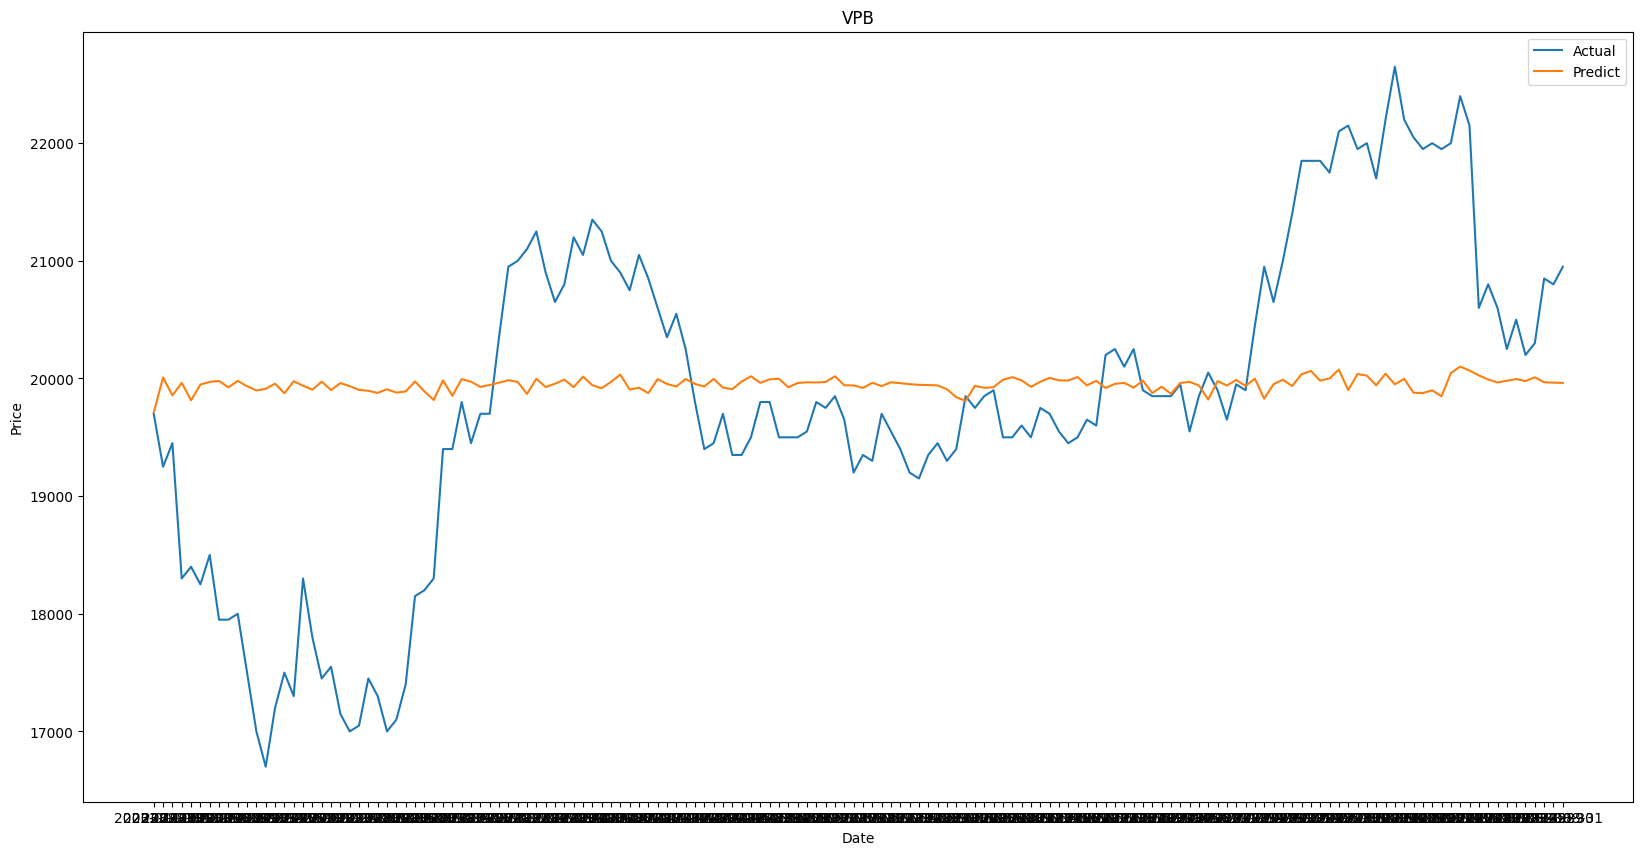

In [67]:
bot.predict_chart('VPB', '2023-01-23', '2023-09-05')

In [72]:
# Dùng algorithm linear
reload(regress)
reload(regress_adapter)

botPhobert = regress_adapter.BotRegress('VPB', '2022-01-01', '2023-07-22', transform_type='sequence', algorithm='linear')
botPhobert.fit()

/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/Users/ngocp/Documents/projects/pyml/botapp/algorithm/regress_adapter.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


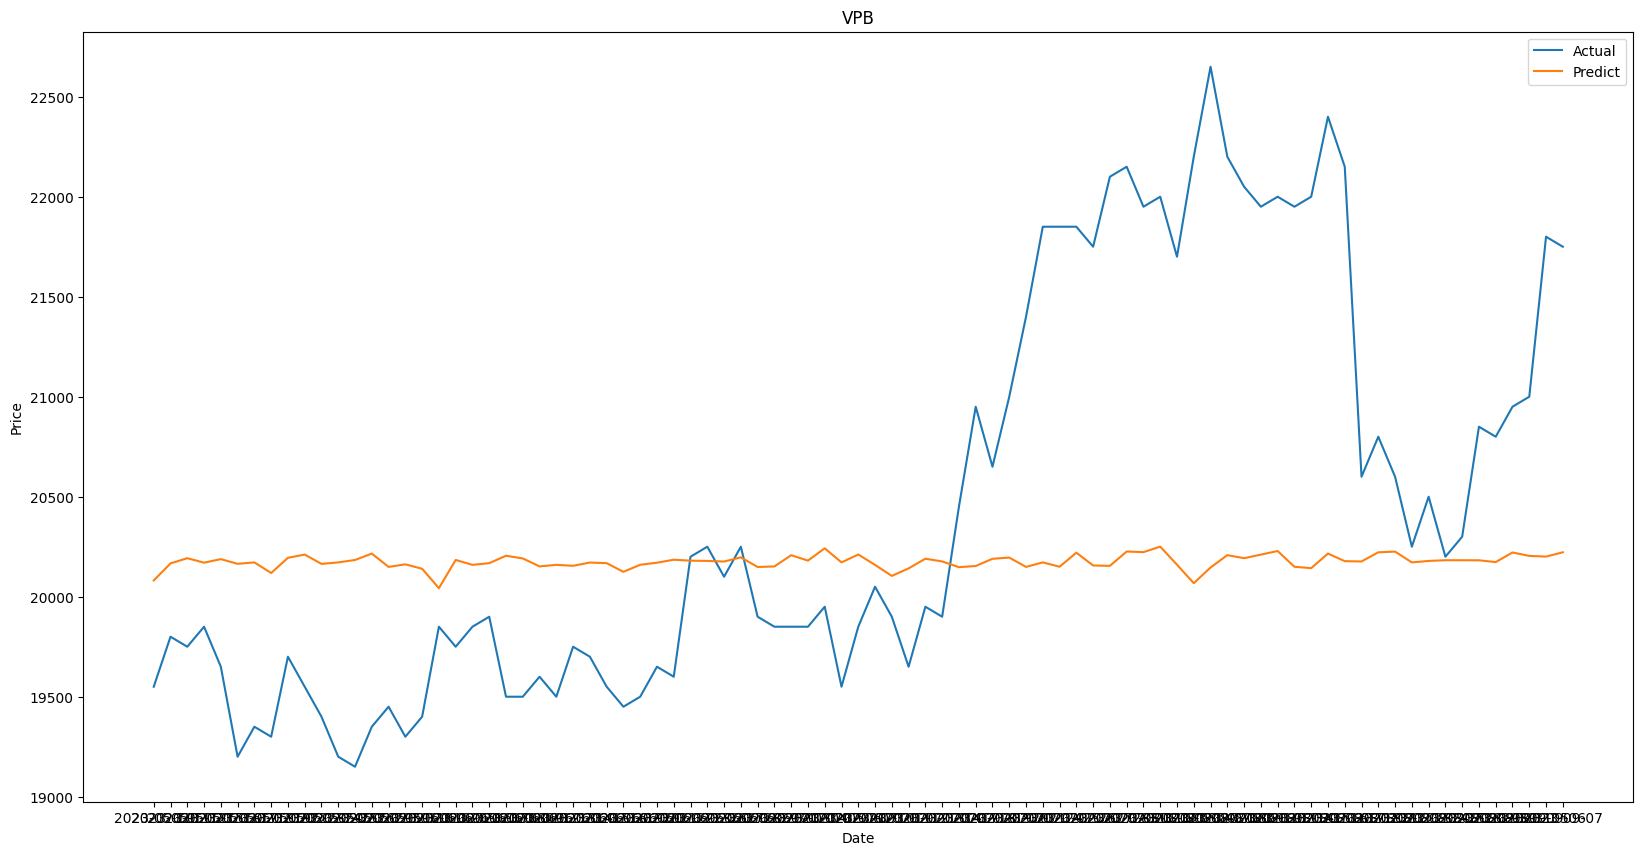

In [73]:
botPhobert.predict_chart('VPB', '2023-05-10', '2023-09-08')

Các thuật toán này có vẻ không hiệu quả, vì cách thức sắp xếp từ chưa đủ để phản ánh các con số về giá cổ phiếu.